In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, maskDiff
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask

def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff):
    mask = maskDiff(diff, window=(20,20), threshold=2)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff):
    mDiff = maskLoop(diff)
    #mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff)
    return mDiff

def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [4]:
n = 512
rot = 179.5
iters = 1
guess = [6.00319194e+01, 2.464, -0.914, -4.92e+01, 2.19754536e-01, 5.02049715e-04]
guess = [6.00319194e+01, 2.45282692e+00, -9.96895755e-01, -4.92e+01, 2.19838173e-01, -5.05770158e-03]
kernel = Gaussian2DKernel(x_stddev=17.)
nZern = 36
maskIters = 3
iz = 4
izv = -167
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 7.85 s, sys: 1.58 s, total: 9.43 s
Wall time: 6.98 s


In [6]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir) # Ref scan
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 4.47 s, sys: 1.23 s, total: 5.7 s
Wall time: 3.52 s


In [7]:
%%time
xmin, xmax = gridLimits(xs, xr)
ymin, ymax = gridLimits(ys, yr)
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 1min 43s, sys: 2.9 s, total: 1min 45s
Wall time: 1min 41s


In [8]:
%%time
print(np.nansum(zrg*zsg))

383782908.9601815
CPU times: user 3.75 ms, sys: 3.99 ms, total: 7.73 ms
Wall time: 6.51 ms


In [376]:
inf = np.inf
pi2 = 2*np.pi
b1 = [59., 2.464-1e-3, -0.914-1e-3, -49.2-1e-4, -pi2, -pi2]
b2 = [61., 2.464+1e-3, -0.914+1e-3, -49.2+1e-4,  pi2,  pi2]
b1 = [59., -5, -5, -49.2-1e-3, -pi2, -pi2]
b2 = [61.,  5,  5, -49.2+1e-3,  pi2,  pi2]
b1 = [59., -inf, -inf, -49.2-1e-4, -pi2, -pi2]
b2 = [61.,  inf,  inf, -49.2+1e-4,  pi2,  pi2]
bounds = (b1, b2)
#bounds = None

In [377]:
%%time
zrgs = convolve(zrg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zrsFit, zrsMask = parabolaFitIterations(xrg, yrg, zrgs,
                                        guess=guess, bounds=bounds, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
zsgs = convolve(zsg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zssFit, zssMask = parabolaFitIterations(xsg, ysg, zsgs,
                                        guess=guess, bounds=bounds, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
print(zrsFit.x)
print(zssFit.x)

[ 6.00546423e+01  2.46494381e+00 -9.14907381e-01 -4.92001000e+01
  2.19754536e-01  5.02049740e-04]
[ 6.00583206e+01  2.46925780e+00 -9.21890823e-01 -4.92001000e+01
  2.19799826e-01  5.70028871e-04]
CPU times: user 9min, sys: 7min 47s, total: 16min 47s
Wall time: 56.9 s


In [378]:
pFitR = np.copy(zrsFit.x)
pFitS = np.copy(zssFit.x)
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)
xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)

In [379]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 11.4 s, sys: 2.64 s, total: 14 s
Wall time: 8.72 s


In [380]:
zroff = 0#np.nanmean(zrag[256-10:256+10,0:10])
zsoff = 0#np.nanmean(zsag[256-10:256+10,0:10])

<IPython.core.display.Javascript object>


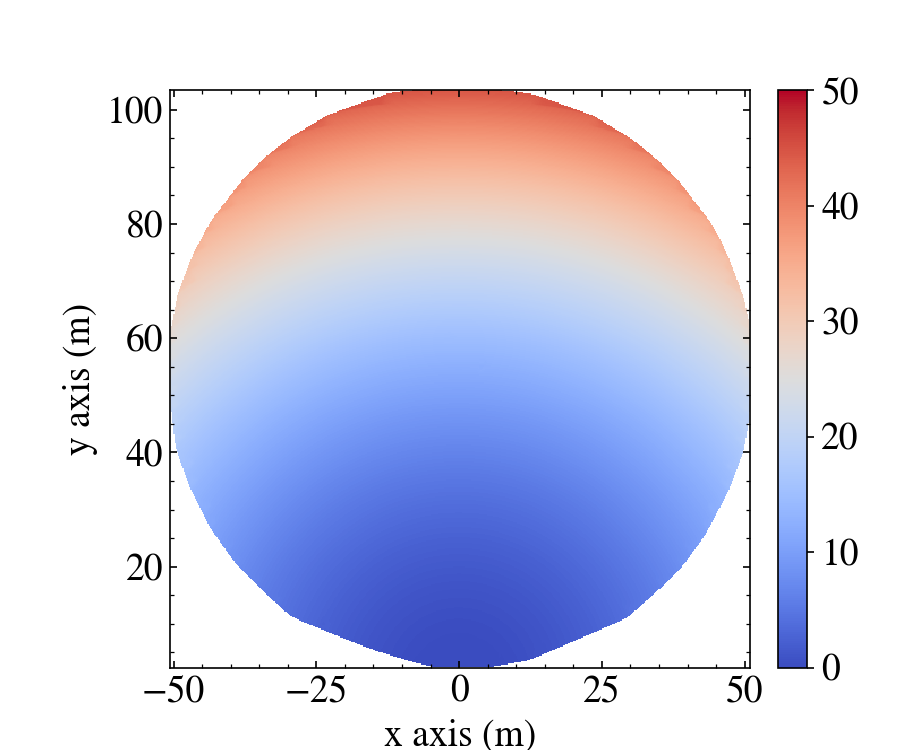

In [381]:
surfacePlot(xrag, yrag, zrag.T - zroff, vMin=0, vMax=50, midPoint=25)

<IPython.core.display.Javascript object>


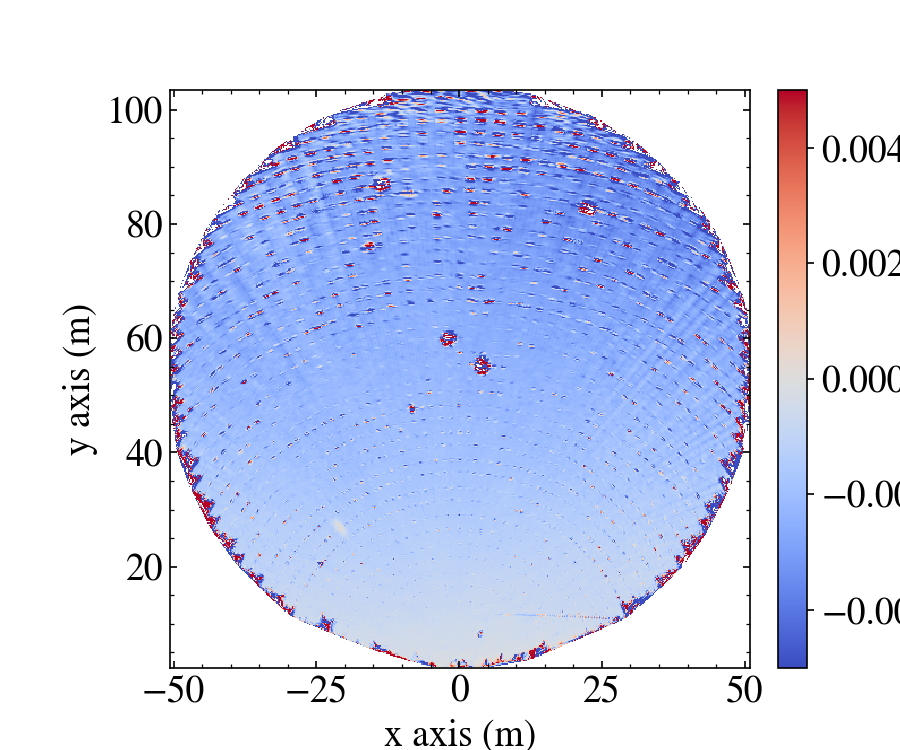

In [382]:
diff = np.ma.masked_invalid((zsag - zsoff) - (zrag - zroff))
#diff = np.ma.masked_outside(diff, -5e-3, 5e-3)
diff = sigma_clip(diff, 10)
surfacePlot(xrag, yrag, diff.T)

<IPython.core.display.Javascript object>


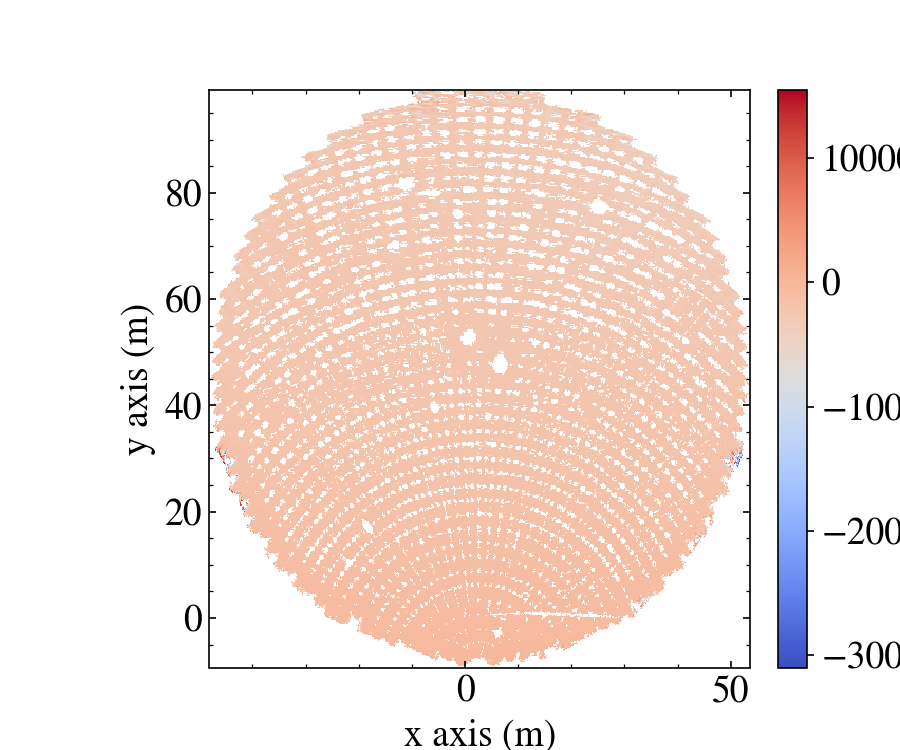

CPU times: user 19.6 s, sys: 9.95 s, total: 29.6 s
Wall time: 29.6 s


In [383]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    mDiff0 = maskData(diff)
    for i in range(maskIters):
        mDiff0 = maskData(mDiff0)
    
vmin = np.nanmin(mDiff0*1e6)
vmax = np.nanmax(mDiff0*1e6)
surfacePlot(xrg, yrg, mDiff0.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


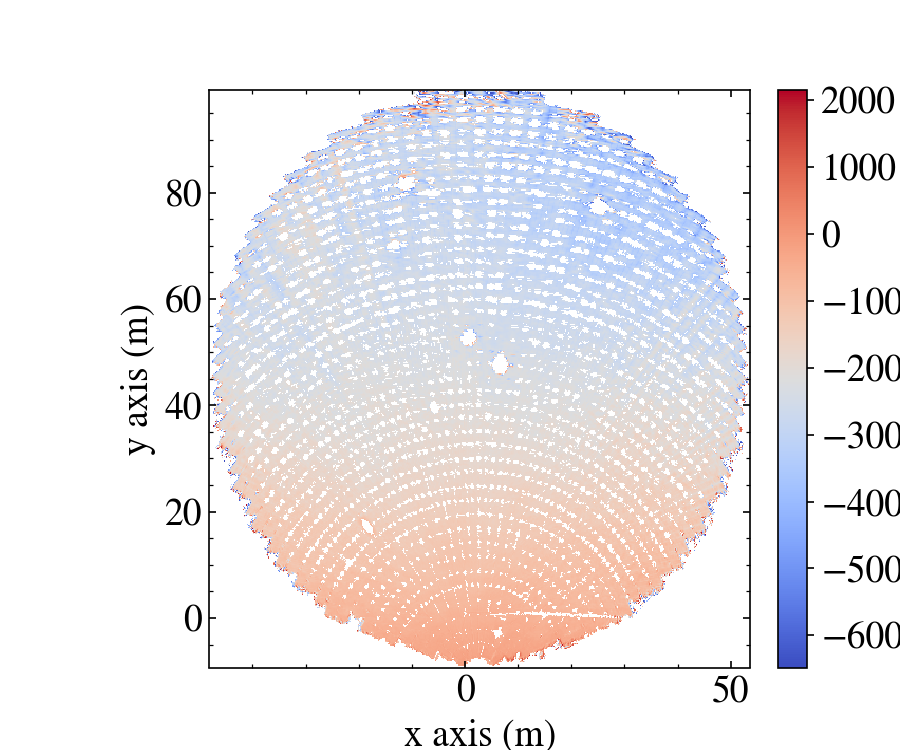

In [384]:
mDiff0_ = sigma_clip(mDiff0, 5)
vmin = np.nanmin(mDiff0_*1e6)
vmax = np.nanmax(mDiff0_*1e6)
surfacePlot(xrg, yrg, mDiff0_.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


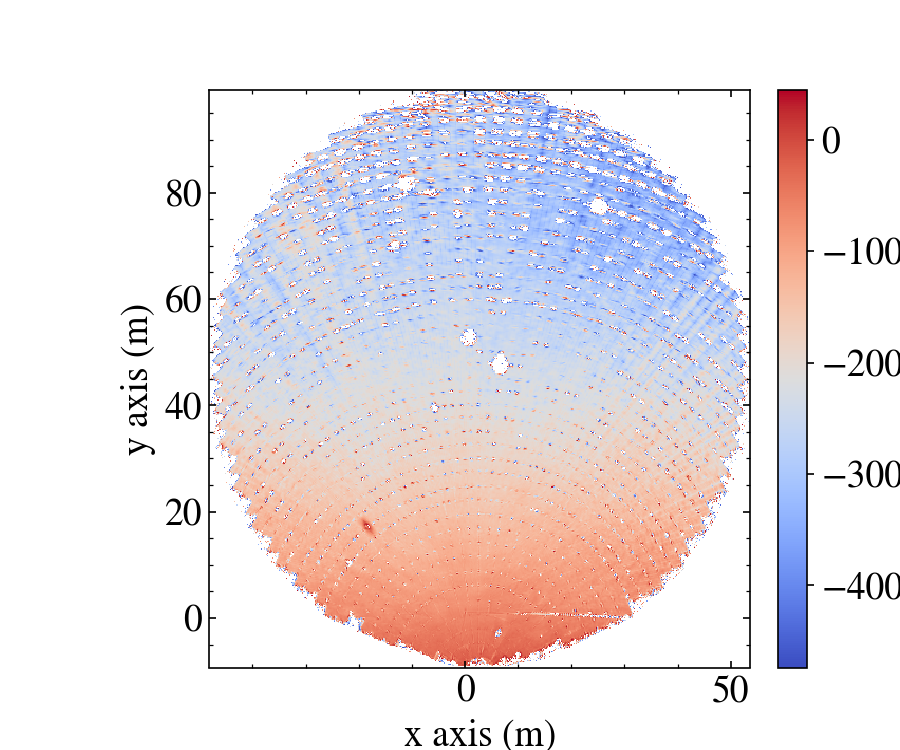

In [396]:
diff = sigma_clip(np.ma.masked_invalid(diff), 3)
vmin = np.nanmin(diff*1e6)
vmax = np.nanmax(diff*1e6)
surfacePlot(xrg, yrg, diff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

In [397]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    mDiff1 = maskData(diff)

<IPython.core.display.Javascript object>


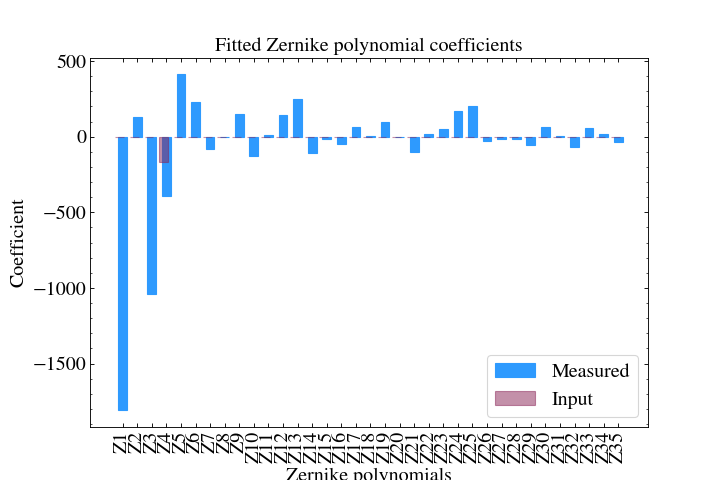

-393.06663059758915


In [398]:
fl_fs = getZernikeCoeffs(mDiff1.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

Number of iterations: 4


<IPython.core.display.Javascript object>


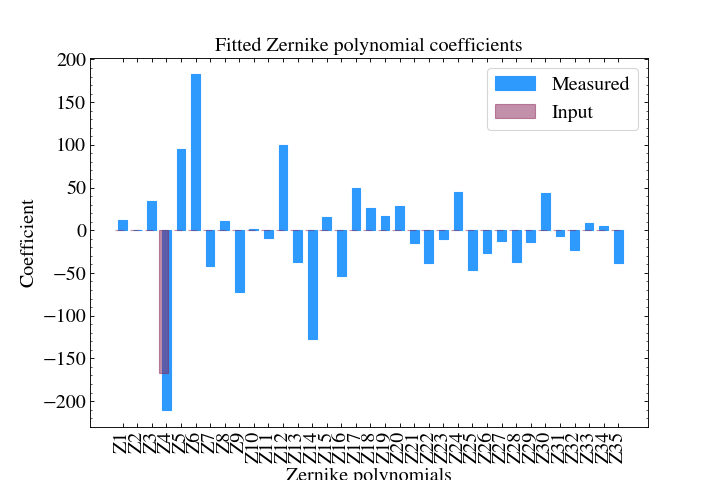

-210.94510959665362


<IPython.core.display.Javascript object>


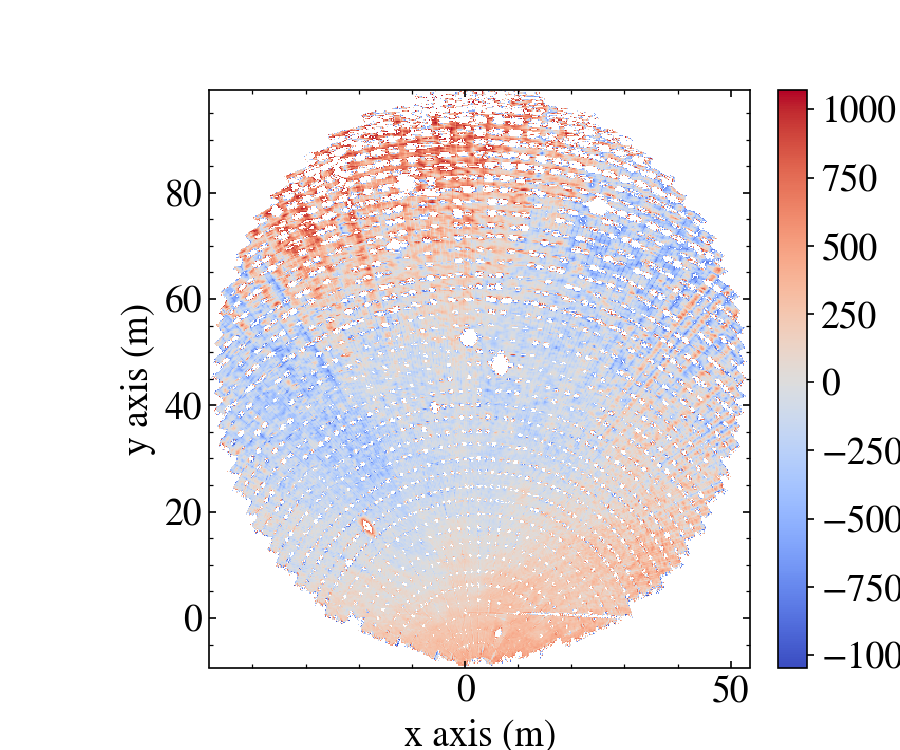

In [401]:
diff_ = np.ma.copy(sigma_clip(diff_))
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

In [406]:
np.sum(np.power(fl_fs_sub, 2.)), np.power(np.nanstd(diff_), 2.)

(1.0907814148474433e-07, 5.888533601317351e-08)

In [404]:
diff1_ = maskData(diff_)

/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:129: RuntimeWarning: invalid value encountered in greater
  return mask
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:129: RuntimeWarning: invalid value encountered in greater
  return mask


Number of iterations: 5


<IPython.core.display.Javascript object>


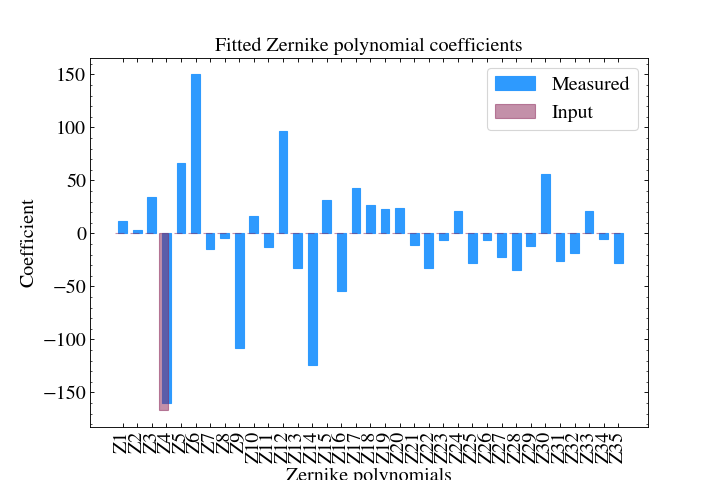

-159.79638764773


<IPython.core.display.Javascript object>


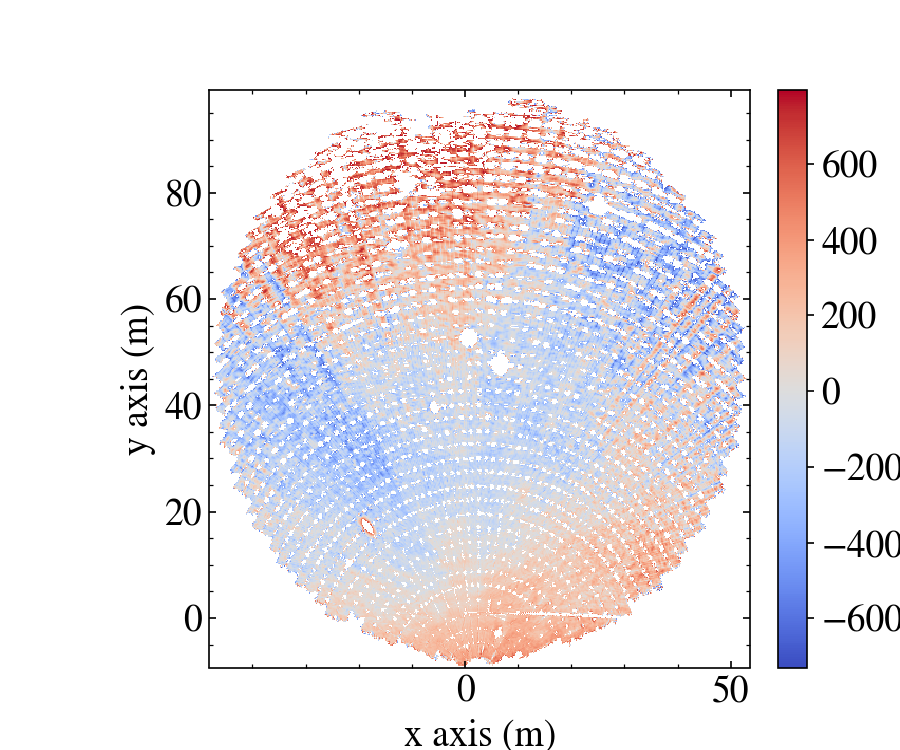

In [405]:
diff_ = np.ma.copy(sigma_clip(diff1_))
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))